In [135]:
#Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#sklearn preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc

# Base Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Tree-Based and Ensemble Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


#for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [4]:
# Loading the dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  "diabetes.csv"
)

df.head()

Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Y Data profiling

In [1]:
!pip install ydata-profiling


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.7 MB/s eta 0:00:00


In [5]:
from ydata_profiling import ProfileReport

profile = ProfileReport( df , title="Diabetes Classification Dataset", explorative = True  )

profile.to_file("ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 50.59it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Separate X and y

In [46]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

#Numerical Column and Categorical Columns

In [47]:
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [48]:
numeric_features

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [49]:
categorical_features

Index([], dtype='object')

# Data visualization for checking outliers

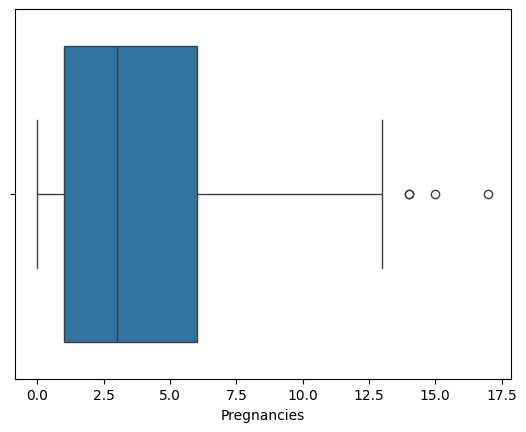

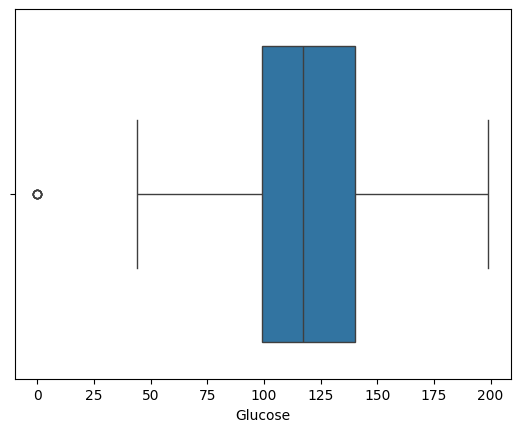

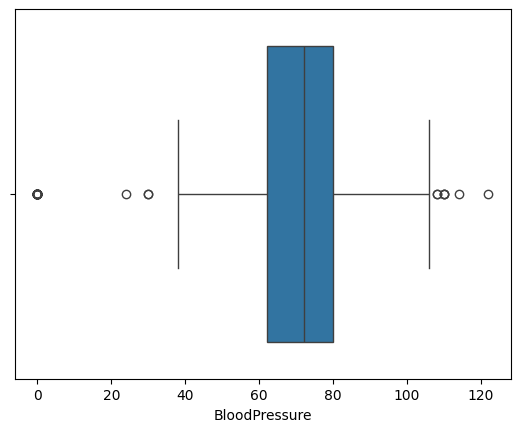

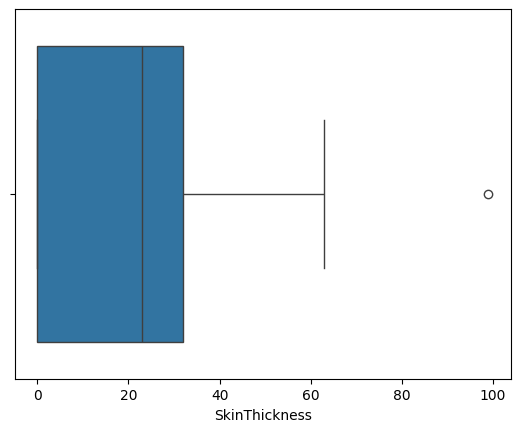

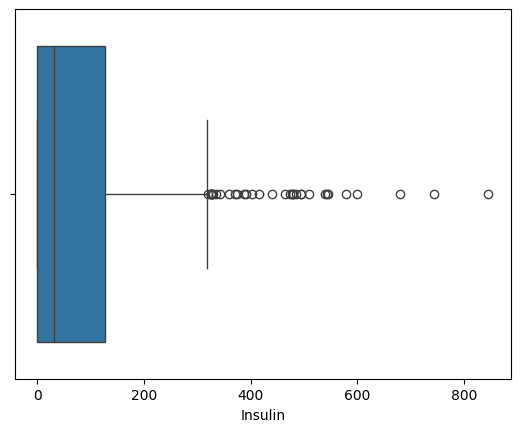

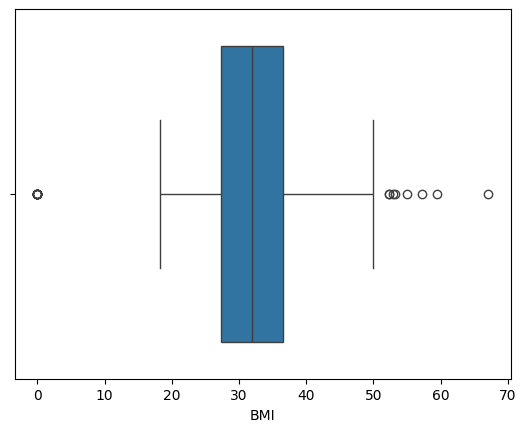

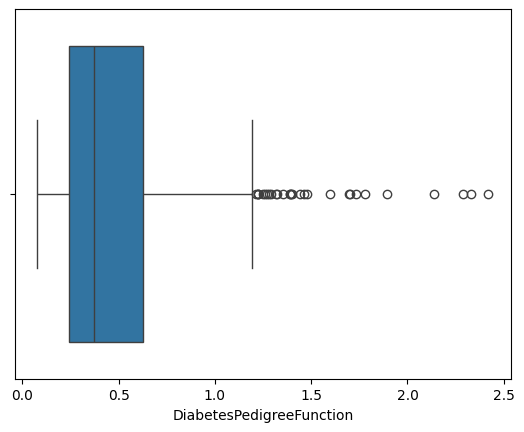

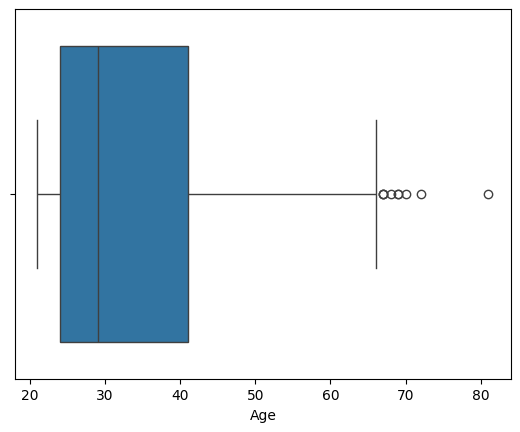

In [10]:
for col in X.columns:
    sns.boxplot(x=X[col])
    plt.show()

# Train Test Split

In [50]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

# Prepocessing


## Hadling Zeros

In [58]:
cols_with_zeros = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
X_train[cols_with_zeros] = X_train[cols_with_zeros].replace(0, np.nan)
X_test[cols_with_zeros] = X_test[cols_with_zeros].replace(0, np.nan)

imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame( imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index )
X_test_imputed = pd.DataFrame( imputer.transform(X_test), columns=X_test.columns, index=X_test.index )

display(X_train_imputed.head())
print()
display(X_test_imputed.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,12.0,43.0,27.2,0.580,24.0
711,5.0,126.0,78.0,27.0,22.0,29.6,0.439,40.0
373,2.0,105.0,58.0,40.0,94.0,34.9,0.225,25.0
46,1.0,146.0,56.0,29.0,125.0,29.7,0.564,29.0
682,0.0,95.0,64.0,39.0,105.0,44.6,0.366,22.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
44,7.0,159.0,64.0,29.0,125.0,27.4,0.294,40.0
672,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0
700,2.0,122.0,76.0,27.0,200.0,35.9,0.483,26.0
630,7.0,114.0,64.0,29.0,125.0,27.4,0.732,34.0
81,2.0,74.0,72.0,29.0,125.0,32.4,0.102,22.0



## Feature Engineering

### For X_train

In [63]:
X_train_imputed_copy = X_train_imputed.copy()

X_train_imputed_copy['BMI_Category'] = np.where(X_train_imputed_copy['BMI'] < 18.5, "Underweight",
    np.where((X_train_imputed_copy['BMI'] >= 18.5) & (X_train_imputed_copy['BMI'] <= 24.9), "Healthy",
    np.where((X_train_imputed_copy['BMI'] > 24.9) & (X_train_imputed_copy['BMI'] <= 29.9), "Overweight",
    np.where((X_train_imputed_copy['BMI'] > 29.9) & (X_train_imputed_copy['BMI'] <= 34.9), "Obesity 1",
    np.where((X_train_imputed_copy['BMI'] > 34.9) & (X_train_imputed_copy['BMI'] <= 39.9), "Obesity 2", "Obesity 3")))))


X_train_imputed_copy['Glucose_Category'] = np.where(X_train_imputed_copy['Glucose'] < 140, "Normal",
    np.where((X_train_imputed_copy['Glucose'] >= 140) & (X_train_imputed_copy['Glucose'] <= 199), "Pre_diabetes", "Diabetes")
)


X_train_imputed_copy['BP_Category'] = np.where(X_train_imputed_copy['BloodPressure'] < 80, "Normal",
    np.where((X_train_imputed_copy['BloodPressure'] >= 80) & (X_train_imputed_copy['BloodPressure'] <= 89), "Hypertension 1", "Hypertension 2")
)

X_train_binning = X_train_imputed_copy.drop(['Glucose','BloodPressure','BMI'], axis=1)

X_train_binning.head()


,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,BMI_Category,Glucose_Category,BP_Category
353,1.0,12.0,43.0,0.580,24.0,Overweight,Normal,Normal
711,5.0,27.0,22.0,0.439,40.0,Overweight,Normal,Normal
373,2.0,40.0,94.0,0.225,25.0,Obesity 1,Normal,Normal
46,1.0,29.0,125.0,0.564,29.0,Overweight,Pre_diabetes,Normal
682,0.0,39.0,105.0,0.366,22.0,Obesity 3,Normal,Normal


### For X_test

In [62]:
X_test_imputed_copy = X_test_imputed.copy()

X_test_imputed_copy['BMI_Category'] = np.where(X_test_imputed_copy['BMI'] < 18.5, "Underweight",
    np.where((X_test_imputed_copy['BMI'] >= 18.5) & (X_test_imputed_copy['BMI'] <= 24.9), "Healthy",
    np.where((X_test_imputed_copy['BMI'] > 24.9) & (X_test_imputed_copy['BMI'] <= 29.9), "Overweight",
    np.where((X_test_imputed_copy['BMI'] > 29.9) & (X_test_imputed_copy['BMI'] <= 34.9), "Obesity 1",
    np.where((X_test_imputed_copy['BMI'] > 34.9) & (X_test_imputed_copy['BMI'] <= 39.9), "Obesity 2", "Obesity 3")))))


X_test_imputed_copy['Glucose_Category'] = np.where(X_test_imputed_copy['Glucose'] < 140, "Normal",
    np.where((X_test_imputed_copy['Glucose'] >= 140) & (X_test_imputed_copy['Glucose'] <= 199), "Pre_diabetes", "Diabetes")
)


X_test_imputed_copy['BP_Category'] = np.where(X_test_imputed_copy['BloodPressure'] < 80, "Normal",
    np.where((X_test_imputed_copy['BloodPressure'] >= 80) & (X_test_imputed_copy['BloodPressure'] <= 89), "Hypertension 1", "Hypertension 2")
)

X_test_binning = X_test_imputed_copy.drop(['Glucose','BloodPressure','BMI'], axis=1)

X_test_binning.head()


,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,BMI_Category,Glucose_Category,BP_Category
44,7.0,29.0,125.0,0.294,40.0,Overweight,Pre_diabetes,Normal
672,10.0,23.0,49.0,0.285,47.0,Obesity 2,Normal,Hypertension 2
700,2.0,27.0,200.0,0.483,26.0,Obesity 2,Normal,Normal
630,7.0,29.0,125.0,0.732,34.0,Overweight,Normal,Normal
81,2.0,29.0,125.0,0.102,22.0,Obesity 1,Normal,Normal


## Onehot Encoding

### For X_train

In [67]:
binned_train_col = ['Glucose_Category','BP_Category','BMI_Category']

one_hot_trans = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_one_hot = one_hot_trans.fit_transform(X_train_binning[binned_train_col])

X_train_enc = pd.DataFrame(
    X_train_one_hot,
    columns=one_hot_trans.get_feature_names_out(binned_train_col),
    index=X_train_binning.index
)

X_train_binn_drop = X_train_binning.drop(["BMI_Category",	"Glucose_Category",	"BP_Category"], axis=1)
X_train_encoded = pd.concat([X_train_enc, X_train_binn_drop], axis=1)
X_train_encoded.head()


,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
353,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,12.0,43.0,0.580,24.0
711,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,27.0,22.0,0.439,40.0
373,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,40.0,94.0,0.225,25.0
46,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,29.0,125.0,0.564,29.0
682,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,39.0,105.0,0.366,22.0


### For X_test

In [68]:
binned_test_col = ['Glucose_Category','BP_Category','BMI_Category']

X_test_one_hot = one_hot_trans.transform(X_test_binning[binned_test_col])

X_test_enc = pd.DataFrame(
    X_test_one_hot,
    columns=one_hot_trans.get_feature_names_out(binned_test_col),
    index=X_test_binning.index
)

X_test_binn_drop = X_test_binning.drop(["BMI_Category",	"Glucose_Category",	"BP_Category"], axis=1)
X_test_encoded = pd.concat([X_test_enc, X_test_binn_drop], axis=1)
X_test_encoded.head()


,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,29.0,125.0,0.294,40.0
672,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,23.0,49.0,0.285,47.0
700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,27.0,200.0,0.483,26.0
630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,29.0,125.0,0.732,34.0
81,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,29.0,125.0,0.102,22.0


## Performing Log Transform on Pregnancies column

### For X_train

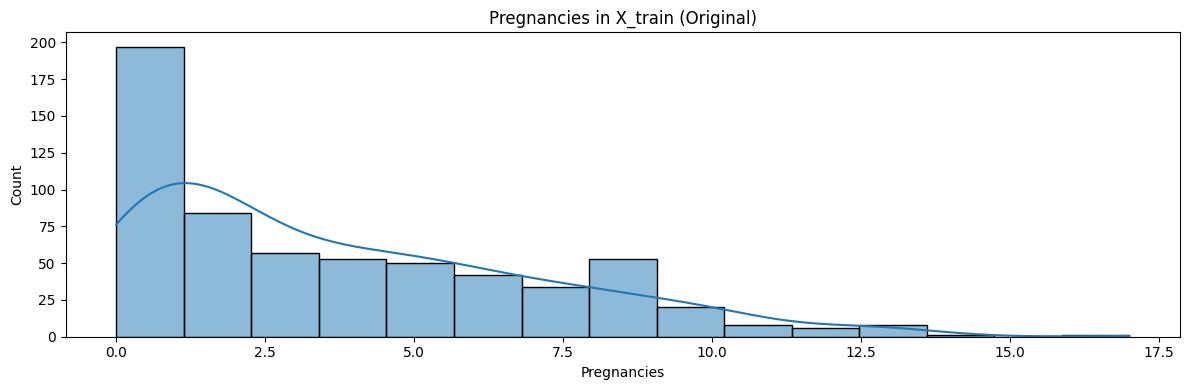

,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
353,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.693147,12.0,43.0,0.580,24.0
711,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.791759,27.0,22.0,0.439,40.0
373,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.098612,40.0,94.0,0.225,25.0
46,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.693147,29.0,125.0,0.564,29.0
682,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,39.0,105.0,0.366,22.0


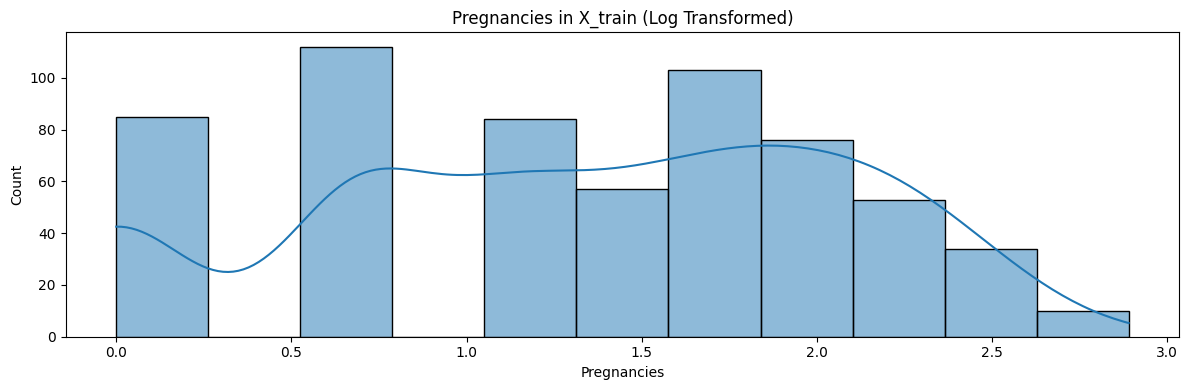

In [70]:
plt.figure(figsize=(12, 4))
sns.histplot(X_train_encoded["Pregnancies"], kde=True)
plt.title(f"Pregnancies in X_train (Original)")
plt.tight_layout()
plt.show()

X_train_log = X_train_encoded.copy()

X_train_log["Pregnancies"] = np.log1p(X_train_log["Pregnancies"])

print()
display(X_train_log.head())
print()

plt.figure(figsize=(12, 4))
sns.histplot(X_train_log["Pregnancies"], kde=True)
plt.title(f"Pregnancies in X_train (Log Transformed)")
plt.tight_layout()
plt.show()

### For X_test

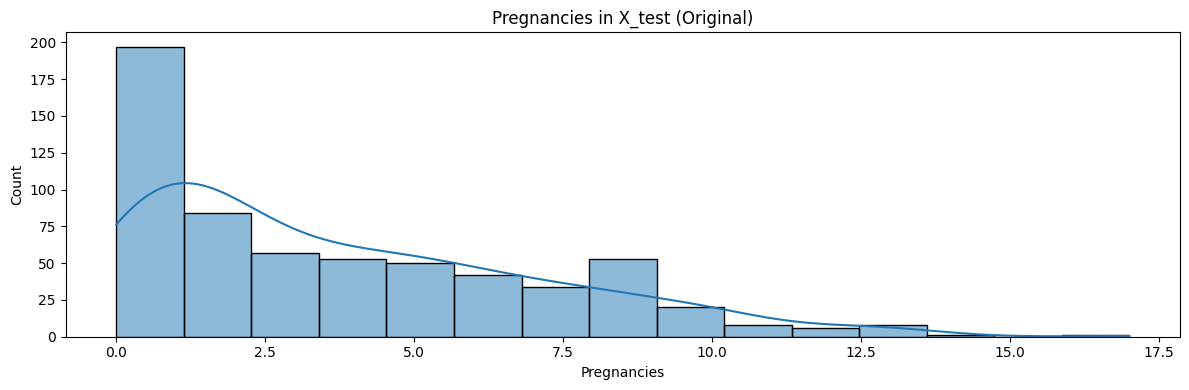

,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.079442,29.0,125.0,0.294,40.0
672,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.397895,23.0,49.0,0.285,47.0
700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.098612,27.0,200.0,0.483,26.0
630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.079442,29.0,125.0,0.732,34.0
81,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.098612,29.0,125.0,0.102,22.0


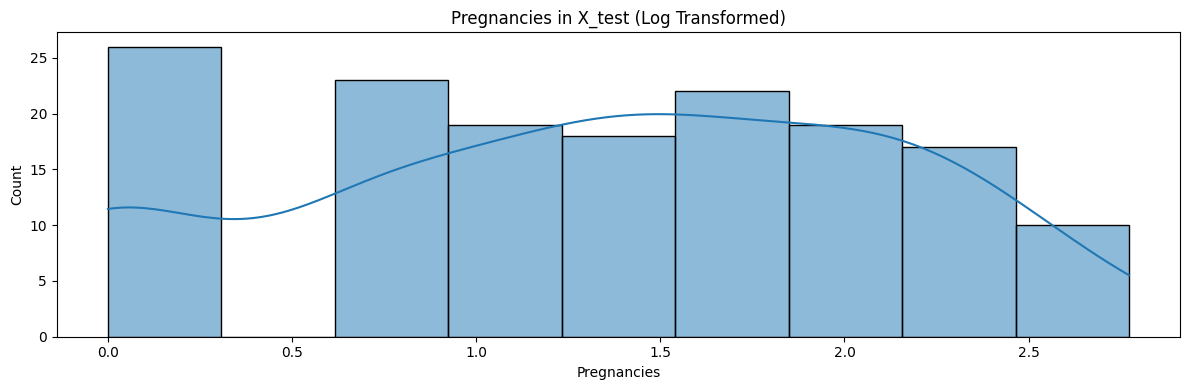

In [72]:
plt.figure(figsize=(12, 4))
sns.histplot(X_train_encoded["Pregnancies"], kde=True)
plt.title(f"Pregnancies in X_test (Original)")
plt.tight_layout()
plt.show()

X_test_log = X_test_encoded.copy()

X_test_log["Pregnancies"] = np.log1p(X_test_log["Pregnancies"])

print()
display(X_test_log.head())
print()

plt.figure(figsize=(12, 4))
sns.histplot(X_test_log["Pregnancies"], kde=True)
plt.title(f"Pregnancies in X_test (Log Transformed)")
plt.tight_layout()
plt.show()

## Removing Outliers

### For encoded data

#### For X_train

In [74]:
numeric_outlier_cols = [
    "Pregnancies",
    "SkinThickness",
    "Insulin",
    "DiabetesPedigreeFunction",
    "Age"
]


X_train_capped = X_train_log.copy()

for col in numeric_outlier_cols:
    Q1 = X_train_capped[col].quantile(0.25)
    Q3 = X_train_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = X_train_capped[(X_train_capped[col] < lower) | (X_train_capped[col] > upper)]
    print(f"Number of detected outliers in {col}:", len(outliers))

    X_train_capped[col] = X_train_capped[col].clip(lower, upper)

X_train_capped.head()


Number of detected outliers in Pregnancies: 0
Number of detected outliers in SkinThickness: 73
Number of detected outliers in Insulin: 253
Number of detected outliers in DiabetesPedigreeFunction: 19
Number of detected outliers in Age: 6


,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
353,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.693147,14.5,105.0,0.580,24.0
711,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.791759,27.0,105.0,0.439,40.0
373,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.098612,40.0,105.0,0.225,25.0
46,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.693147,29.0,125.0,0.564,29.0
682,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,39.0,105.0,0.366,22.0


#### For X_test

In [76]:
numeric_outlier_cols = [
    "Pregnancies",
    "SkinThickness",
    "Insulin",
    "DiabetesPedigreeFunction",
    "Age"
]


X_test_capped = X_test_log.copy()

for col in numeric_outlier_cols:
    Q1 = X_test_capped[col].quantile(0.25)
    Q3 = X_test_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = X_test_capped[(X_test_capped[col] < lower) | (X_test_capped[col] > upper)]
    print(f"Number of detected outliers in {col}:", len(outliers))

    X_test_capped[col] = X_test_capped[col].clip(lower, upper)

X_test_capped.head()


Number of detected outliers in Pregnancies: 0
Number of detected outliers in SkinThickness: 14
Number of detected outliers in Insulin: 70
Number of detected outliers in DiabetesPedigreeFunction: 8
Number of detected outliers in Age: 3


,Glucose_Category_Normal,Glucose_Category_Pre_diabetes,BP_Category_Hypertension 1,BP_Category_Hypertension 2,BP_Category_Normal,BMI_Category_Healthy,BMI_Category_Obesity 1,BMI_Category_Obesity 2,BMI_Category_Obesity 3,BMI_Category_Overweight,BMI_Category_Underweight,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Age
44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.079442,29.0,125.0,0.294,40.0
672,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.397895,23.0,125.0,0.285,47.0
700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.098612,27.0,125.0,0.483,26.0
630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.079442,29.0,125.0,0.732,34.0
81,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.098612,29.0,125.0,0.102,22.0


### For data without encoding

#### For X_train

In [78]:
X_train_capped_without_encoding = X_train_imputed.copy()

for col in numeric_outlier_cols:
    Q1 = X_train_capped_without_encoding[col].quantile(0.25)
    Q3 = X_train_capped_without_encoding[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = X_train_capped_without_encoding[(X_train_capped_without_encoding[col] < lower) | (X_train_capped_without_encoding[col] > upper)]
    print(f"Number of detected outliers in {col}:", len(outliers))

    X_train_capped_without_encoding[col] = X_train_capped_without_encoding[col].clip(lower, upper)

X_train_capped_without_encoding.head()


Number of detected outliers in Pregnancies: 2
Number of detected outliers in SkinThickness: 73
Number of detected outliers in Insulin: 253
Number of detected outliers in DiabetesPedigreeFunction: 19
Number of detected outliers in Age: 6


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1.0,90.0,62.0,14.5,105.0,27.2,0.580,24.0
711,5.0,126.0,78.0,27.0,105.0,29.6,0.439,40.0
373,2.0,105.0,58.0,40.0,105.0,34.9,0.225,25.0
46,1.0,146.0,56.0,29.0,125.0,29.7,0.564,29.0
682,0.0,95.0,64.0,39.0,105.0,44.6,0.366,22.0


#### For X_test

In [80]:
X_test_capped_without_encoding = X_test_imputed.copy()

for col in numeric_outlier_cols:
    Q1 = X_test_capped_without_encoding[col].quantile(0.25)
    Q3 = X_test_capped_without_encoding[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = X_test_capped_without_encoding[(X_test_capped_without_encoding[col] < lower) | (X_test_capped_without_encoding[col] > upper)]
    print(f"Number of detected outliers in {col}:", len(outliers))

    X_test_capped_without_encoding[col] = X_test_capped_without_encoding[col].clip(lower, upper)

X_test_capped_without_encoding.head()


Number of detected outliers in Pregnancies: 2
Number of detected outliers in SkinThickness: 14
Number of detected outliers in Insulin: 70
Number of detected outliers in DiabetesPedigreeFunction: 8
Number of detected outliers in Age: 3


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
44,7.0,159.0,64.0,29.0,125.0,27.4,0.294,40.0
672,10.0,68.0,106.0,23.0,125.0,35.5,0.285,47.0
700,2.0,122.0,76.0,27.0,125.0,35.9,0.483,26.0
630,7.0,114.0,64.0,29.0,125.0,27.4,0.732,34.0
81,2.0,74.0,72.0,29.0,125.0,32.4,0.102,22.0


In [82]:
X_train_enc = X_train_capped
X_test_enc = X_test_capped
X_train = X_train_capped_without_encoding
X_test = X_test_capped_without_encoding

## ydata after preprocessing

### For data with encoding and log_transform

In [83]:
y_and_x = pd.concat([X_train_enc, y_train], axis=1)

profile = ProfileReport( y_and_x , title="Diabetes Preprocessing for Unencoded Data", explorative = True  )

profile.to_file("ydata_preprocessing_unencoded.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:00<00:00, 52.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### For data without encoding and log_transform

In [84]:
y_and_x = pd.concat([X_train, y_train], axis=1)

profile = ProfileReport( y_and_x , title="Diabetes Preprocessing for Encoded Data", explorative = True  )

profile.to_file("ydata_preprocessing_encoded.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 112.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Pipeline for Models

## Primary Model Selection

I have choosen Logistic regression because:  
1) We can explain the cause for diabetes easily with this model
2) The dataset is small and logistic regression is good with small dataset.
3) The dataset is linear in nature (for example: if the glucose level in blood rises then the patience is more risk to have diabetes.)

In [122]:
primary_model = LogisticRegression(
        class_weight="balanced",
        C=1.0,
        max_iter=2000
    )

primary_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [123]:
y_pred_primary = primary_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_primary)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_primary))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_primary))

Test Accuracy: 0.7338

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.61      0.69      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154


Confusion Matrix:
[[76 24]
 [17 37]]


## Base Models

### For Data without Encoding and Log_transform

In [86]:
Base_models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        C=1.0,
        max_iter=2000
    ),
    "SVC": SVC(
        kernel="rbf",
        class_weight="balanced",
        C=1.0,
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights="distance",
        p=2
    ),
    "Naive Bayes": GaussianNB()
}

cv_results_base = []
for name, clf in Base_models.items():
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    scores_base = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    cv_results_base.append({
        'model': name,
        'avg_score': scores_base.mean(),
        'std_dev': scores_base.std()
    })

cv_results_base_df = pd.DataFrame(cv_results_base)
cv_results_base_df

,model,avg_score,std_dev
0,Logistic Regression,0.765520,0.026036
1,SVC,0.757377,0.032767
2,KNN,0.750900,0.029680
3,Naive Bayes,0.750780,0.018018


### With Encoding and Log_transform

In [87]:
Base_models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        C=1.0,
        max_iter=2000
    ),
    "SVC": SVC(
        kernel="rbf",
        class_weight="balanced",
        C=1.0,
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights="distance",
        p=2
    ),
    "Naive Bayes": GaussianNB()
}

cv_results_base = []
for name, clf in Base_models.items():
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    scores_base = cross_val_score(model, X_train_enc, y_train, cv=5, scoring='accuracy')

    cv_results_base.append({
        'model': name,
        'avg_score': scores_base.mean(),
        'std_dev': scores_base.std()
    })

cv_results_base_df = pd.DataFrame(cv_results_base)
cv_results_base_df

,model,avg_score,std_dev
0,Logistic Regression,0.745955,0.042989
1,SVC,0.724750,0.024383
2,KNN,0.716647,0.023390
3,Naive Bayes,0.459283,0.020887


### Base models with RandomizedSearchCV

### For Data without Encoding and Log_transform

In [88]:
base_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=2000),
    "SVC": SVC(class_weight="balanced", probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

base_params = {
    "Logistic Regression": {
        'poly__degree': [1, 2, 3],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.1, 0.5, 0.7, 0.9]
    },
    "SVC": {
        'poly__degree': [1, 2, 3],
        'clf__C': [0.1, 1, 10, 50, 100, 500],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'clf__kernel': ['rbf', 'linear', 'poly']
    },
    "KNN": {
        'poly__degree': [1, 2, 3],
        'clf__n_neighbors': range(3, 30, 2),
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        'clf__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "Naive Bayes": {
        'clf__var_smoothing': np.logspace(-10, -1, 20)
    }
}

results_base = []

for name, clf in base_models.items():
    pipe = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    if name in base_params:
        rand_search_base = RandomizedSearchCV(
            pipe,
            param_distributions=base_params[name],
            n_iter=15,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        rand_search_base.fit(X_train, y_train)

        test_acc_base = rand_search_base.score(X_test, y_test)
        results_base.append({
            'model': name,
            'parameters_tested': base_params[name],
            'best_params': rand_search_base.best_params_,
            'cv_score': rand_search_base.best_score_,
            'test_score': test_acc_base
        })

results_base_df = pd.DataFrame(results_base)
results_base_df[['model', 'best_params', 'cv_score', 'test_score']]

,model,best_params,cv_score,test_score
0,Logistic Regression,"{'poly__degree': 3, 'clf__solver': 'saga', 'cl...",0.775250,0.740260
1,SVC,"{'poly__degree': 1, 'clf__kernel': 'linear', '...",0.762255,0.740260
2,KNN,"{'poly__degree': 2, 'clf__weights': 'distance'...",0.778582,0.733766
3,Naive Bayes,{'clf__var_smoothing': 0.1},0.752419,0.714286


In [102]:
#best parameters of Logistic Regression
display(results_base_df.loc[0][2])
print()


#best parameters of SVC
results_base_df.loc[1][2]

{'poly__degree': 1,
 'clf__solver': 'saga',
 'clf__penalty': 'l2',
 'clf__l1_ratio': 0.9,
 'clf__C': 0.001}

{'poly__degree': 1,
 'clf__kernel': 'linear',
 'clf__gamma': 'scale',
 'clf__C': 100}

### For Data with Encoding and Log_transform

In [90]:
base_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=2000),
    "SVC": SVC(class_weight="balanced", probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

base_params = {
    "Logistic Regression": {
        'poly__degree': [1, 2, 3],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.1, 0.5, 0.7, 0.9]
    },
    "SVC": {
        'poly__degree': [1, 2, 3],
        'clf__C': [0.1, 1, 10, 50, 100, 500],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'clf__kernel': ['rbf', 'linear', 'poly']
    },
    "KNN": {
        'poly__degree': [1, 2, 3],
        'clf__n_neighbors': range(3, 30, 2),
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        'clf__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "Naive Bayes": {
        'poly__degree': [1, 2, 3],
        'clf__var_smoothing': np.logspace(-10, -1, 20)
    }
}

results_base = []

for name, clf in base_models.items():
    pipe = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    if name in base_params:
        rand_search_base = RandomizedSearchCV(
            pipe,
            param_distributions=base_params[name],
            n_iter=15,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        rand_search_base.fit(X_train_enc, y_train)

        test_acc_base = rand_search_base.score(X_test_enc, y_test)
        results_base.append({
            'model': name,
            'parameters_tested': base_params[name],
            'best_params': rand_search_base.best_params_,
            'cv_score': rand_search_base.best_score_,
            'test_score': test_acc_base
        })
results_base_df = pd.DataFrame(results_base)
results_base_df[['model', 'best_params', 'cv_score', 'test_score']]

,model,best_params,cv_score,test_score
0,Logistic Regression,"{'poly__degree': 1, 'clf__solver': 'saga', 'cl...",0.758963,0.675325
1,SVC,"{'poly__degree': 1, 'clf__kernel': 'linear', '...",0.736172,0.688312
2,KNN,"{'poly__degree': 1, 'clf__weights': 'uniform',...",0.752446,0.727273
3,Naive Bayes,"{'poly__degree': 1, 'clf__var_smoothing': 0.1}",0.718193,0.655844


In [103]:
#best parameters of KNN
results_base_df.loc[2][2]

{'poly__degree': 1,
 'clf__weights': 'uniform',
 'clf__p': 2,
 'clf__n_neighbors': 29,
 'clf__metric': 'minkowski'}

## Tree Models

### For Data without Encoding and Log_transform

In [92]:
tree_models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion="gini",
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
}

tree_models_results = []
for name,clf in tree_models.items():
  model = Pipeline([
      ('poly', PolynomialFeatures(degree=2, include_bias=False)),
      ('clf', clf)
      ])

  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  tree_models_results.append({'model': name,
                  'accuracy_train': accuracy_score(y_train, y_train_pred),
                  'f1_train': f1_score(y_train, y_train_pred),
                  'accuracy_test': accuracy_score(y_test, y_test_pred),
                  'f1_test': f1_score(y_test, y_test_pred)
                  })
tree_models_results_df = pd.DataFrame(tree_models_results)
tree_models_results_df

,model,accuracy_train,f1_train,accuracy_test,f1_test
0,Decision Tree,0.858306,0.771654,0.714286,0.551020
1,Random Forest,0.903909,0.869757,0.727273,0.631579


### Tree models with RandomizedSearchCV

### For Data without Encoding and Log_transform

In [93]:
tree_models_tuning = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
}

tree_params = {
    "Decision Tree": {
        'poly__degree': [1, 2, 3],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 3, 5, 7, 10, 15, 20],
        'clf__min_samples_split': [2, 5, 10, 15, 20],
        'clf__min_samples_leaf': [1, 2, 4, 6, 8],
        'clf__max_features': [None, 'sqrt', 'log2']
    },
    "Random Forest": {
        'poly__degree': [1, 2, 3],
        'clf__n_estimators': [100, 200, 500, 800],
        'clf__max_depth': [None, 10, 15, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False],
        'clf__max_features': ['sqrt', 'log2', None]
    }
}

tree_tuning_results = []

for name, clf in tree_models_tuning.items():
    pipe = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('clf', clf)
    ])

    rand_search_tree = RandomizedSearchCV(
        pipe,
        param_distributions=tree_params[name],
        n_iter=15,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    rand_search_tree.fit(X_train, y_train)

    test_acc_tree = rand_search_tree.score(X_test, y_test)
    tree_tuning_results.append({
        'model': name,
        'parameters_tested': tree_params[name],
        'best_params': rand_search_tree.best_params_,
        'cv_score': rand_search_tree.best_score_,
        'test_score': test_acc_tree
        })

tree_tuning_results_df = pd.DataFrame(tree_tuning_results)


In [94]:
tree_tuning_results_df[['model', 'best_params', 'cv_score', 'test_score']]

,model,best_params,cv_score,test_score
0,Decision Tree,"{'poly__degree': 3, 'clf__min_samples_split': ...",0.745888,0.714286
1,Random Forest,"{'poly__degree': 1, 'clf__n_estimators': 500, ...",0.771985,0.746753


In [95]:
# Best parameter of random forest
tree_tuning_results_df.loc[1][2]

{'poly__degree': 1,
 'clf__n_estimators': 500,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 4,
 'clf__max_features': 'log2',
 'clf__max_depth': 30,
 'clf__bootstrap': True}

## Ensemble models

### For Data without Encoding and Log_transform

In [96]:
ensemble_models = {
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    ),
    "XgBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        random_state=42,
        eval_metric="logloss"
    )
}

ensemble_cv_results = []

for name, clf in ensemble_models.items():
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    ensemble_cv_results.append({
        'model': name,
        'avg_score': scores.mean(),
        'std_dev': scores.std()
    })

ensemble_cv_results_df = pd.DataFrame(ensemble_cv_results)
ensemble_cv_results_df

,model,avg_score,std_dev
0,Gradient Boosting,0.729655,0.043361
1,AdaBoost,0.760629,0.027157
2,XgBoost,0.728015,0.032731


### Ensemble model with RandomizedSearchCV

### For Data without Encoding and Log_transform

In [127]:
ensemble_models_tuning = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XgBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
}

ensemble_param = {
    "Gradient Boosting": {
        'poly__degree': [1, 2, 3],
        'clf__n_estimators': [100, 200, 300,500,1000],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [2, 3, 4],
        'clf__subsample': [0.8, 1.0]
    },
    "AdaBoost": {
        'poly__degree': [1, 2, 3],
        'clf__n_estimators': [100, 200, 300,500,1000],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.5]
    },
    "XgBoost": {
        'poly__degree': [1, 2, 3],
        'clf__n_estimators': [100, 200, 300,500,1000],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 4, 5],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
        'clf__reg_lambda': [0.5, 1.0, 2.0]
    }
}

ensemble_tuning_results = []

for name, clf in ensemble_models_tuning.items():
    pipe = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    rand_search_ensemble = RandomizedSearchCV(
        pipe,
        param_distributions=ensemble_param[name],
        n_iter=15,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    rand_search_ensemble.fit(X_train, y_train)
    test_acc_ensemble = rand_search_ensemble.score(X_test, y_test)
    ensemble_tuning_results.append({
        'model': name,
        'parameters_tested': ensemble_param[name],
        'best_params': rand_search_ensemble.best_params_,
        'cv_score': rand_search_tree.best_score_,
        'test_score': test_acc_ensemble
        })

ensemble_tuning_results_df = pd.DataFrame(ensemble_tuning_results)


In [128]:
ensemble_tuning_results_df[['model', 'parameters_tested', 'best_params', 'cv_score', 'test_score']]

,model,parameters_tested,best_params,cv_score,test_score
0,Gradient Boosting,"{'poly__degree': [1, 2, 3], 'clf__n_estimators': [100, 200, 300, 500, 1000], 'clf__learning_rate...","{'poly__degree': 1, 'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__...",0.771985,0.733766
1,AdaBoost,"{'poly__degree': [1, 2, 3], 'clf__n_estimators': [100, 200, 300, 500, 1000], 'clf__learning_rate...","{'poly__degree': 2, 'clf__n_estimators': 100, 'clf__learning_rate': 0.5}",0.771985,0.733766
2,XgBoost,"{'poly__degree': [1, 2, 3], 'clf__n_estimators': [100, 200, 300, 500, 1000], 'clf__learning_rate...","{'poly__degree': 3, 'clf__subsample': 0.8, 'clf__reg_lambda': 2.0, 'clf__n_estimators': 300, 'cl...",0.771985,0.753247


In [129]:
#Best param of XGboosting
ensemble_tuning_results_df.loc[2][2]

{'poly__degree': 3,
 'clf__subsample': 0.8,
 'clf__reg_lambda': 2.0,
 'clf__n_estimators': 300,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__colsample_bytree': 1.0}

# Best Model:
 - For Base Model : Logistic Regression and SVC (Without Encoded Data)
 - For Tree Model : Random Forest
 - For Ensemble Model : XgBoost
 - Overall Best Model : XgBoost with test accuracy of 0.753247

In [130]:
final_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=300,
        subsample=0.8,
        reg_lambda=2.0,
        max_depth=3,
        learning_rate=0.01,
        colsample_bytree=1.0
    ))
])

final_pipeline.fit(X_train, y_train)

y_pred_final = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Test Accuracy: 0.7532
ROC AUC Score: 0.8220

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

Confusion Matrix:
[[82 18]
 [20 34]]


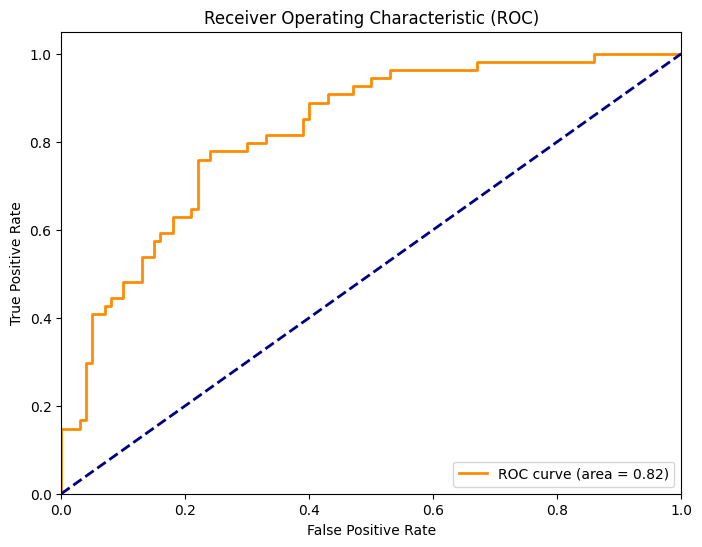

In [136]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Generating Pickle File

In [138]:
filename = "Diabetes_model.pkl"

with open(filename, "wb") as file:
    pickle.dump(final_pipeline, file)

## Necessary preprocessing data

In [139]:
all_medians = dict(zip(X_train.columns, imputer.statistics_))

final_medians = {k: v for k, v in all_medians.items() if k in cols_with_zeros}

final_outlier_limits = {}
for col in numeric_outlier_cols:
    Q1 = X_train_imputed[col].quantile(0.25)
    Q3 = X_train_imputed[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    final_outlier_limits[col] = {
        'lower': round(lower, 4),
        'upper': round(upper, 4)
    }

print("MEDIANS = {")
for col, val in final_medians.items():
    print(f'    "{col}": {val},')
print("}\n")

print("OUTLIER_LIMITS = {")
for col, limits in final_outlier_limits.items():
    print(f'    "{col}": {limits},')
print("}")

MEDIANS = {
    "Glucose": 117.0,
    "BloodPressure": 72.0,
    "SkinThickness": 29.0,
    "Insulin": 125.0,
    "BMI": 32.4,
}

OUTLIER_LIMITS = {
    "Pregnancies": {'lower': np.float64(-6.5), 'upper': np.float64(13.5)},
    "SkinThickness": {'lower': np.float64(14.5), 'upper': np.float64(42.5)},
    "Insulin": {'lower': np.float64(105.0), 'upper': np.float64(145.0)},
    "DiabetesPedigreeFunction": {'lower': np.float64(-0.3464), 'upper': np.float64(1.2306)},
    "Age": {'lower': np.float64(-1.5), 'upper': np.float64(66.5)},
}
